In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

from crowd_tracker_lidar3d.loader import load_data_to_dataframe
from crowd_tracker_lidar3d.plot_tools import plot_pointcloud3d, draw_point_cloud, show_projections
from crowd_tracker_lidar3d.preprocessing import rotate_pcl, df_apply_rot, return_ground_points, remove_ground_points
import matplotlib.pyplot as plt 

In [5]:
walking_dist = 3 

In [50]:
filename = '{}m_1person_labeled-front_lidar-velodyne_points'.format(str(walking_dist))

In [51]:
bag_dir = os.path.dirname(os.path.abspath(''))
bag_dir = os.path.join(bag_dir, "data")
data = load_data_to_dataframe(filename, bag_dir)

### Data Overview

In [52]:
data.shape

(5703670, 6)

In [42]:
data.head()

,rosbagTimestamp,x,y,z,intensity,time
0,1585676291,-1.030228,-0.526967,0.310065,1.0,-0.099263
1,1585676291,-1.063074,-0.539095,0.319383,1.0,-0.099208
2,1585676291,-1.101393,-0.548894,0.329735,1.0,-0.099097
3,1585676291,-1.125818,-0.556170,0.336465,1.0,-0.099042
4,1585676291,-1.178068,-0.576874,0.351476,4.0,-0.098986


In [43]:
# investigate value ranges
x_max, x_min = np.max(data.x), np.min(data.x)
y_max, y_min = np.max(data.y), np.min(data.y)
z_max, z_min = np.max(data.z), np.min(data.z)
intensity_max, intensity_min = np.max(data.intensity), np.min(data.intensity)

print('x_max: {:.3f}, x_min: {:.3f}'.format(x_max, x_min))
print('y_max: {:.3f} y_min: {:.3f}'.format(y_min, y_max))
print('z_max: {:.3f}, z_min: {:.3f}'.format(z_max, z_min))
print('intensity_max: {:.3f}, intensity_min: {:.3f}'.format(intensity_max, intensity_min))
print('\nNumber of points: {}'.format(data.shape[0]))

x_max: 24.621, x_min: -5.045
y_max: -6.891 y_min: 4.699
z_max: 6.225, z_min: -0.526
intensity_max: 148.000, intensity_min: 0.000

Number of points: 5703670


In [53]:
# Number of unique timestamps
timesteps = data.rosbagTimestamp.unique()
len(timesteps)

282

In [12]:
len(data.x.between(2.5,3.5))

5703670

In [13]:
# Analyze pointclouds from first and very last timestamp
start = data[data.rosbagTimestamp == timesteps[0]]
end = data[data.rosbagTimestamp == timesteps[-1]]

In [14]:
print(len(start))
print(len(end))

20079
20346


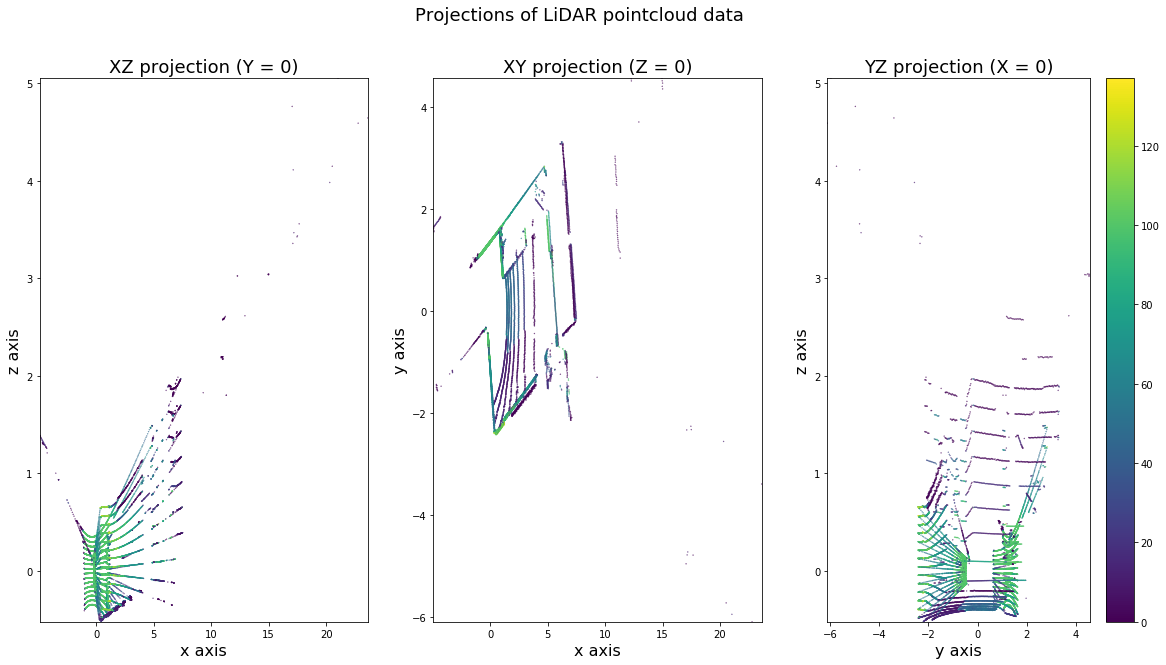

In [15]:
show_projections(start, ['x', 'y', 'z', 'intensity']) #, savefig=True, filename='1m_labeled_raw_timestep0')

### Transform data set and filter floor points

In [16]:
# Set threshold in z-value 
thresh = -0.38

In [17]:
# Rotate points to compensate for LiDAR tilt angle 
start_transformed = df_apply_rot(start)

In [18]:
# Mean difference of z values before and after transformation
np.mean(start_transformed.z - start.z)

-0.11330023590720592

Total number of data points: 20079
Number of data points after filtering for floor points: 15816


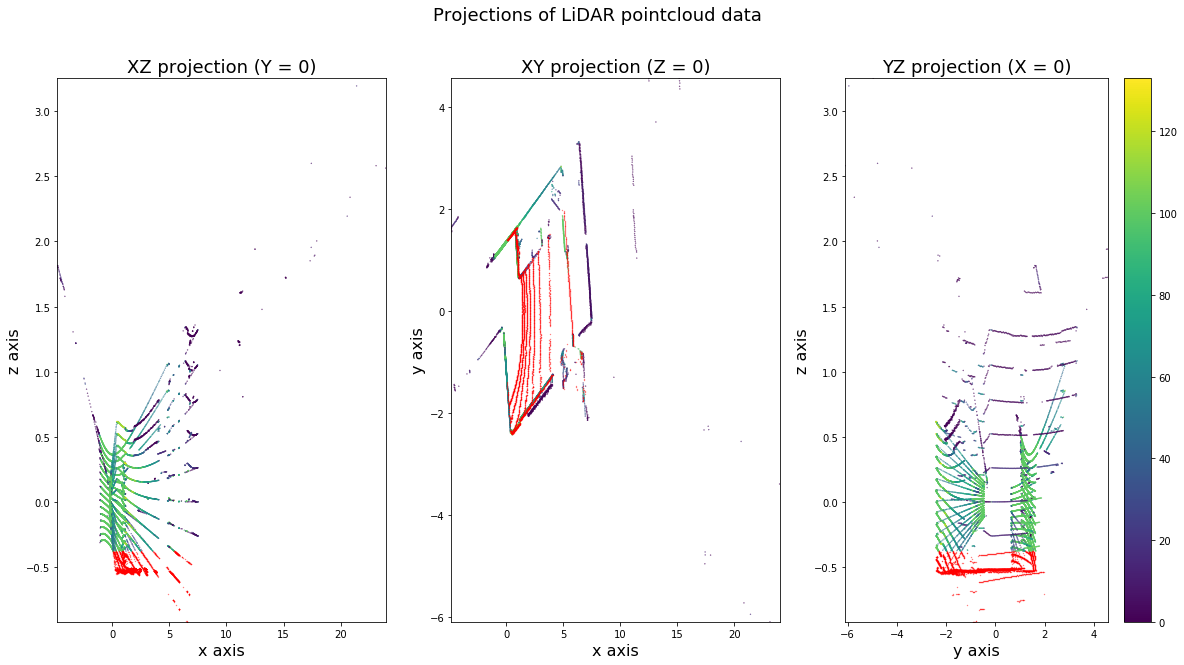

Filtered floor points


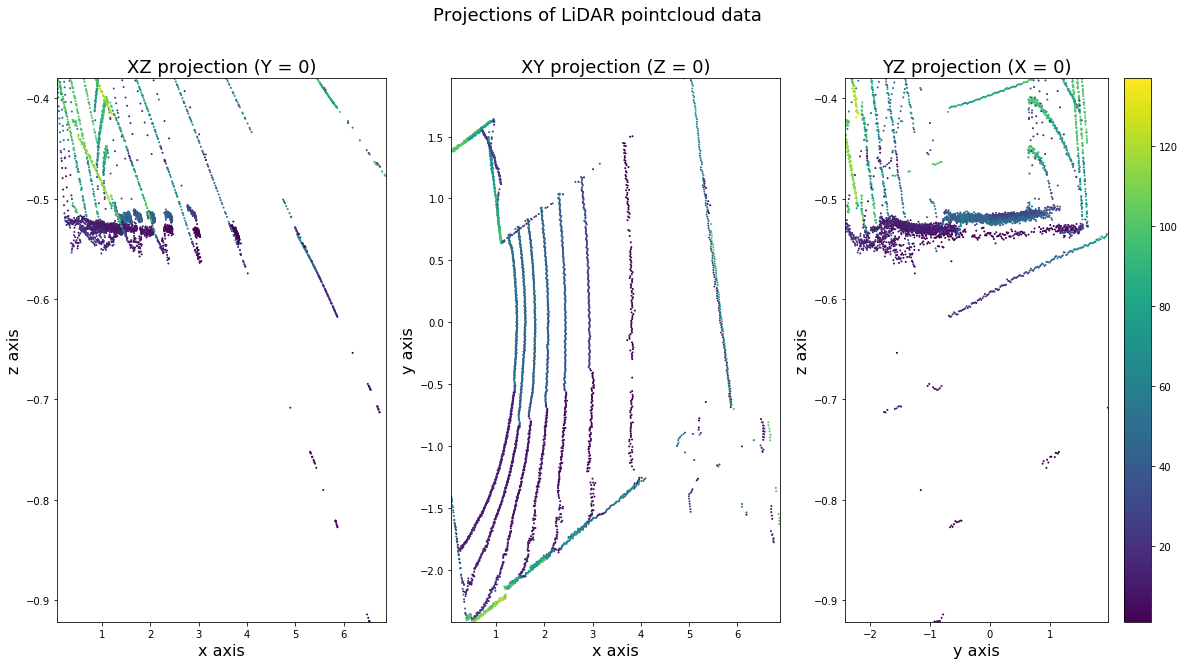

Points selected for segmentation after filtering out floor points


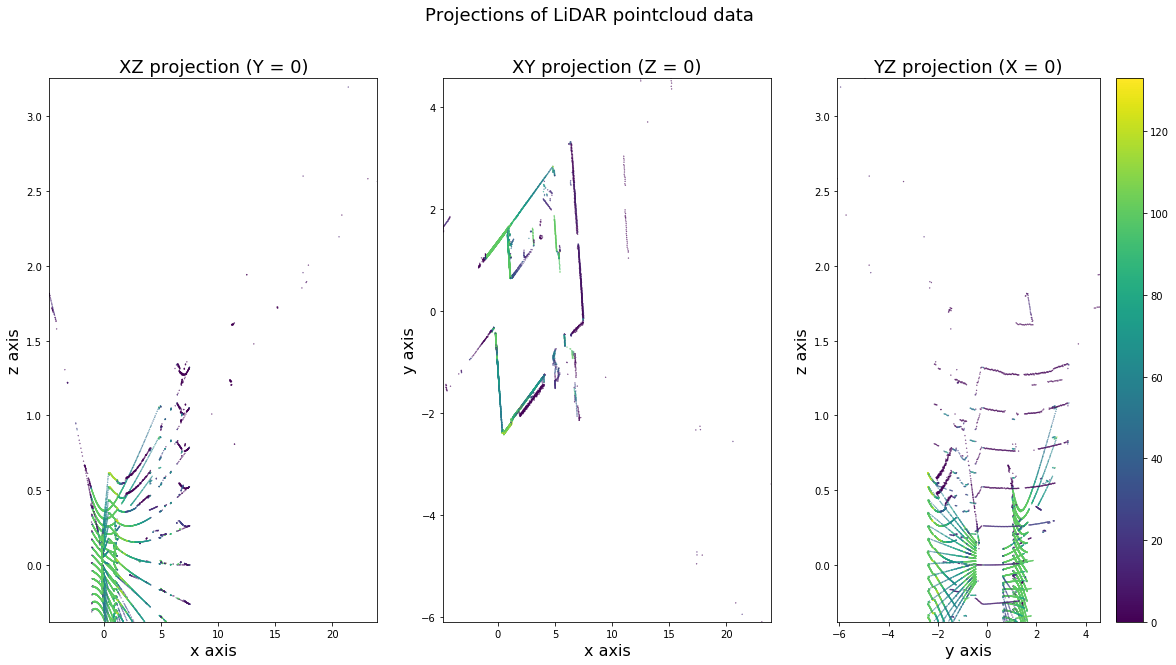

In [20]:
%matplotlib inline
ground_vals_after_rot = return_ground_points(start_transformed, thresh)
start_filtered = remove_ground_points(start_transformed, thresh)
print('Total number of data points: {}\nNumber of data points after filtering for floor points: {}'.format(start_transformed.shape[0], start_filtered.shape[0]))
show_projections(start_filtered, ['x', 'y', 'z', 'intensity'], point_eliminations=ground_vals_after_rot) #, savefig=True, filename='3m_labeled_point_eliminations_rotated_start')
print('Filtered floor points')
show_projections(ground_vals_after_rot, ['x', 'y', 'z', 'intensity']) #, savefig=True, filename='3m_labeled_floorpoints_rotated_start')
print('Points selected for segmentation after filtering out floor points')
show_projections(start_filtered, ['x', 'y', 'z', 'intensity']) #, savefig=True, filename='3m_labeled_data_wo_floor_rotated_start')

## Extract Ground Truth 

### A) By knowing distance at which dataset was measured

In [21]:
# Preprocessing: transform data 
data_transformed = df_apply_rot(data)

In [22]:
np.mean(data_transformed.x - data.x)

0.0024596339959730056

In [23]:
for i, t in enumerate(timesteps):
#     df = data[(data.rosbagTimestamp== t) & (data.x.between(2.5, 3.5))]
    df = data[data.rosbagTimestamp== t]
    ground_truth = df[df.x.between(2.8, 3.5)]
    print('timestep {}: {:.2f} % of points within walking distance, absolute amount: {}'.format(i, 100*float(ground_truth.shape[0])/float(df.shape[0]), ground_truth.shape[0]))

timestep 0: 3.84 % of points within walking distance, absolute amount: 772
timestep 1: 3.86 % of points within walking distance, absolute amount: 775
timestep 2: 3.86 % of points within walking distance, absolute amount: 776
timestep 3: 3.91 % of points within walking distance, absolute amount: 786
timestep 4: 3.89 % of points within walking distance, absolute amount: 781
timestep 5: 3.88 % of points within walking distance, absolute amount: 779
timestep 6: 3.86 % of points within walking distance, absolute amount: 774
timestep 7: 3.88 % of points within walking distance, absolute amount: 779
timestep 8: 3.88 % of points within walking distance, absolute amount: 780
timestep 9: 3.88 % of points within walking distance, absolute amount: 779
timestep 10: 3.86 % of points within walking distance, absolute amount: 774
timestep 11: 3.87 % of points within walking distance, absolute amount: 776
timestep 12: 3.86 % of points within walking distance, absolute amount: 774
timestep 13: 3.87 % of

timestep 125: 4.94 % of points within walking distance, absolute amount: 991
timestep 126: 4.98 % of points within walking distance, absolute amount: 997
timestep 127: 4.90 % of points within walking distance, absolute amount: 984
timestep 128: 4.80 % of points within walking distance, absolute amount: 964
timestep 129: 5.00 % of points within walking distance, absolute amount: 1002
timestep 130: 5.20 % of points within walking distance, absolute amount: 1043
timestep 131: 5.24 % of points within walking distance, absolute amount: 1051
timestep 132: 5.28 % of points within walking distance, absolute amount: 1061
timestep 133: 5.17 % of points within walking distance, absolute amount: 1036
timestep 134: 5.06 % of points within walking distance, absolute amount: 1015
timestep 135: 4.96 % of points within walking distance, absolute amount: 996
timestep 136: 4.92 % of points within walking distance, absolute amount: 987
timestep 137: 5.15 % of points within walking distance, absolute amoun

timestep 236: 5.46 % of points within walking distance, absolute amount: 1092
timestep 237: 5.32 % of points within walking distance, absolute amount: 1065
timestep 238: 5.09 % of points within walking distance, absolute amount: 1019
timestep 239: 4.91 % of points within walking distance, absolute amount: 983
timestep 240: 4.34 % of points within walking distance, absolute amount: 870
timestep 241: 3.92 % of points within walking distance, absolute amount: 785
timestep 242: 3.86 % of points within walking distance, absolute amount: 773
timestep 243: 3.84 % of points within walking distance, absolute amount: 771
timestep 244: 3.86 % of points within walking distance, absolute amount: 775
timestep 245: 3.87 % of points within walking distance, absolute amount: 777
timestep 246: 3.89 % of points within walking distance, absolute amount: 781
timestep 247: 3.86 % of points within walking distance, absolute amount: 775
timestep 248: 3.88 % of points within walking distance, absolute amount: 

564
350


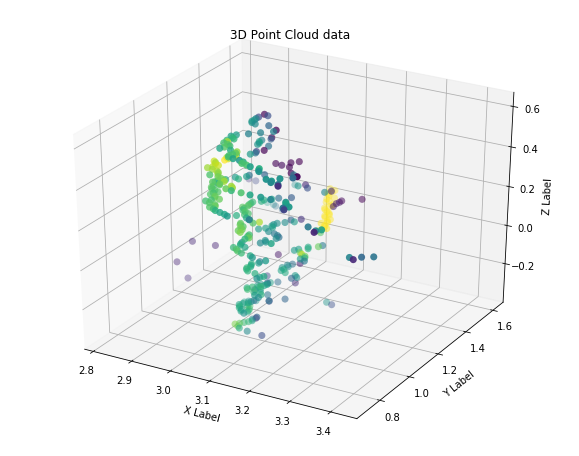

(0.7140030860900879, 1.6117109060287476)


In [24]:
test = data[data.rosbagTimestamp == timesteps[150]].reset_index()
test_trans = df_apply_rot(test)
test_trans = test_trans[(test_trans.x.between(2.8, 3.5)) & (test_trans.y.between(-1, 2))]
print(len(test_trans))
test_trans = remove_ground_points(test_trans, -0.38)
print(len(test_trans))
# test_trans.shape[0]
plot_pointcloud3d(test_trans)
# show_projections(test_trans, ['x', 'y', 'z', 'intensity'])
# test_trans.head()
print(np.min(test_trans.y), np.max(test_trans.y))

### B) Via DROW Detector 

In [79]:
det_file = '{}m_1person_labeled-drow_detected_persons'.format(walking_dist)
detections = load_data_to_dataframe(det_file, bag_dir)

In [80]:
detections.head()

,rosbagTimestamp,detection_id,confidence,det_x,det_y,det_z,height
0,1585676291995056759,156,0.596226,4.765054,-0.918280,1.0,1.85
1,1585676293500363159,157,0.453330,3.278968,-0.820169,1.0,1.85
2,1585676293606525671,158,0.525579,3.250573,-0.835925,1.0,1.85
3,1585676293834309911,159,0.457082,3.189745,-0.841848,1.0,1.85
4,1585676293932619159,160,0.641975,3.132249,-0.803441,1.0,1.85


In [81]:
detections.shape

(119, 7)

In [123]:
print(len(detections.rosbagTimestamp.unique()))
print(len(data.rosbagTimestamp.unique()))

119
282


In [ ]:
# Match closest available detection to each timestamp in data 

# lst = np.asarray(lst) 
idx = (np.abs(lst - K)).argmin() 
return lst[idx] 

In [84]:
df_with_detections = pd.merge(data, detections, on='rosbagTimestamp', how='inner')

In [85]:
data.shape

(5703670, 6)

In [86]:
df_with_detections.shape

(100957, 12)

In [87]:
df_with_detections.head()

,rosbagTimestamp,x,y,z,intensity,time,detection_id,confidence,det_x,det_y,det_z,height
0,1585676298103549479,1.465516,-0.088865,-0.393405,48.0,-0.098944,175,0.722079,2.608869,0.591069,1.0,1.85
1,1585676298103549479,5.800400,-0.352735,0.101433,73.0,-0.098941,175,0.722079,2.608869,0.591069,1.0,1.85
2,1585676298103549479,1.637796,-0.099885,-0.378818,48.0,-0.098939,175,0.722079,2.608869,0.591069,1.0,1.85
3,1585676298103549479,6.610629,-0.403165,0.347092,2.0,-0.098937,175,0.722079,2.608869,0.591069,1.0,1.85
4,1585676298103549479,1.842017,-0.112663,-0.358721,48.0,-0.098934,175,0.722079,2.608869,0.591069,1.0,1.85


In [88]:
det_timesteps = df_with_detections.rosbagTimestamp.unique()
print(len(det_timesteps))

5


In [96]:
# Activate interactive plotting mode to be able to zoom in 
%matplotlib notebook


80


<IPython.core.display.Javascript object>


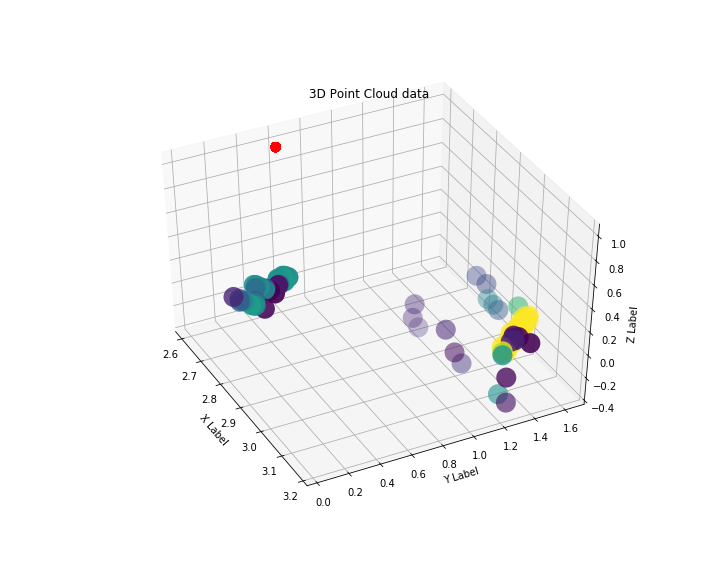

325


<IPython.core.display.Javascript object>


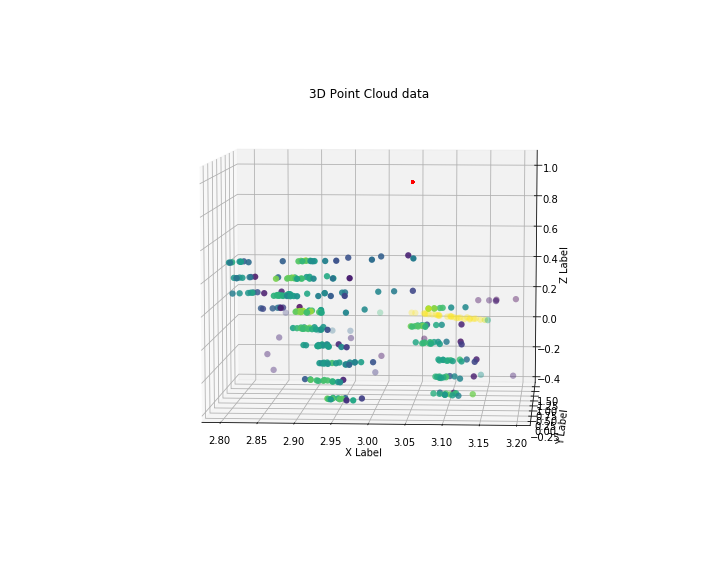

303


<IPython.core.display.Javascript object>


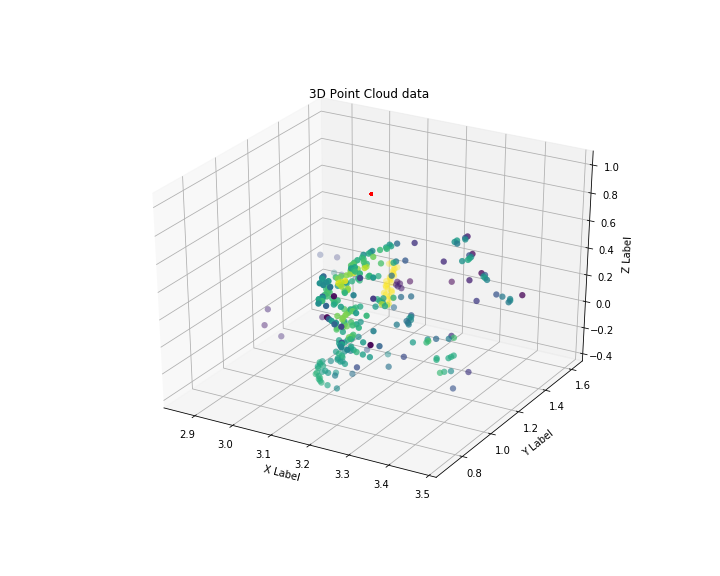

239


<IPython.core.display.Javascript object>


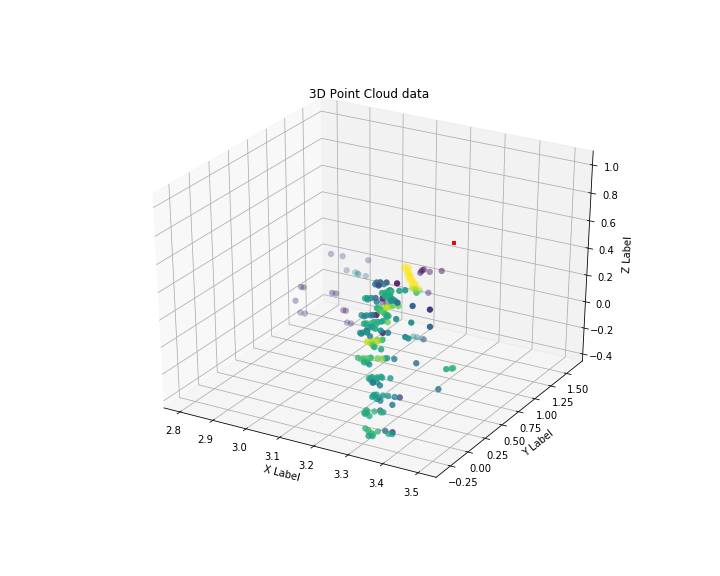

In [107]:
for i,t in enumerate(det_timesteps):
    x = df_with_detections[df_with_detections.rosbagTimestamp == det_timesteps[i]].reset_index()
    x_trans = df_apply_rot(x)
    x_trans = x_trans[(x_trans.x.between(2.8, 3.5)) & (x_trans.y.between(-1, 2))]
    x_trans = remove_ground_points(x_trans, -0.38)
    no_points = x_trans.shape[0]
    point_size = 10**(3- int(np.log10(no_points))) # Adjust point size based on point cloud size
    print(len(x_trans))
    
    
    plt.ion()
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_trans['x'], x_trans['y'], x_trans['z'], c=x_trans['intensity'], s=point_size*4, edgecolor='', marker='o')
    ax.scatter(x.det_x, x.det_y, x.det_z, c= 'r', s=point_size*4, edgecolor='', marker='.')
    
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.title('3D Point Cloud data')
    plt.show()
    if i == 3: 
        break

### SEGMENTATION - Clustering

In [114]:
# Data 
cluster_data = x_trans.to_numpy()
print(cluster_data.shape)

(239, 4)


In [119]:
from sklearn.cluster import DBSCAN
# eps = search radius -- most important hyperparam of dbscan 
# choose eps as 5x/10x/... point cloud resolution which is ~+/-3cm within 10m
clustering = DBSCAN(eps=0.45,min_samples=10, leaf_size=30, algorithm='kd_tree').fit(cluster_data)

In [120]:
labels = clustering.labels_
#  Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 190


In [32]:
# Activate interactive plotting mode to be able to zoom in 
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


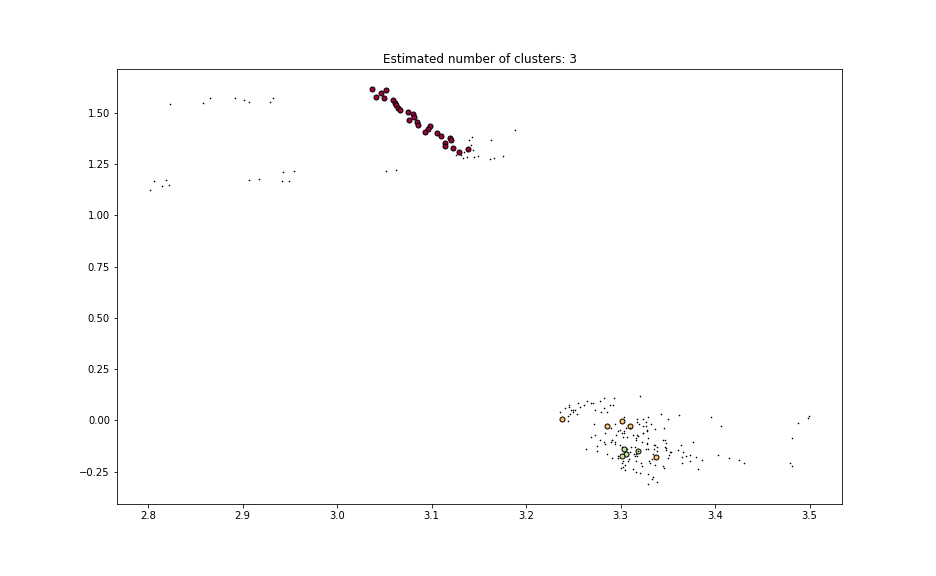

In [121]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True

fig = plt.figure(figsize=[13, 8])

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = cluster_data[class_member_mask & core_samples_mask]
    
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    xy = cluster_data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'x', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

<IPython.core.display.Javascript object>


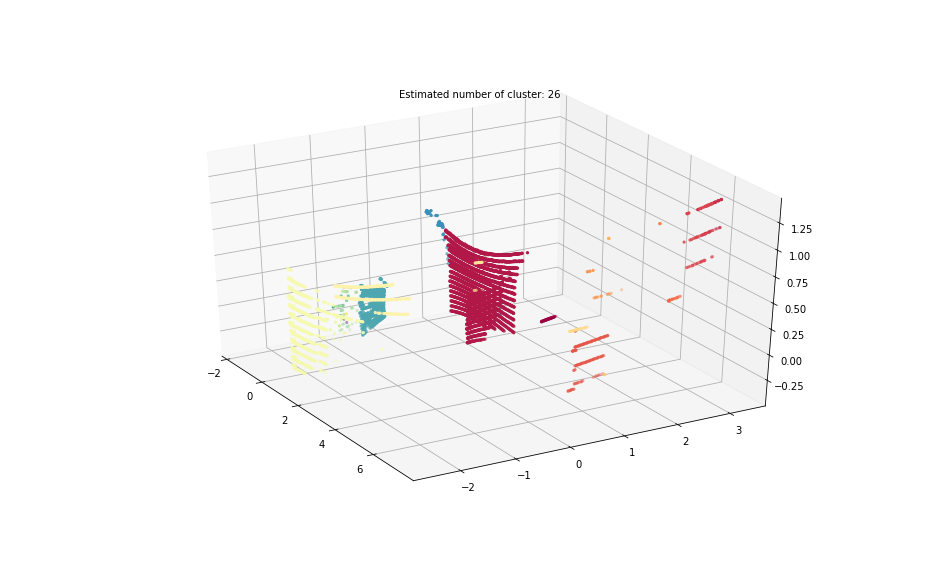

In [30]:
fig = plt.figure(figsize=[13, 8])
ax = fig.add_subplot(111, projection='3d')
# unique_labels = set(labels)
colors = [plt.cm.Spectral(each)  for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):  
    if k == -1:    # Black used for noise.    
        col = [0, 0, 0, 1]  
    class_member_mask = (labels == k)  
    xyz = cluster_data[class_member_mask & core_samples_mask]  
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=col, marker=".")
plt.title('Estimated number of cluster: %d' % n_clusters_, fontsize=10)
plt.show()

## Preprocessing - Testing
Testing a ground plane segmentation approach taken from [here](https://towardsdatascience.com/point-cloud-data-simple-approach-f3855fdc08f5)

In [145]:
dataset.shape

(20302, 3)

In [150]:
dataset[:, 2].min()

-0.5173874497413635

In [18]:
def frange(start, stop, step):  
    i = start  
    while i < stop:    
        yield i    
        i += step

dataset = start_transformed[['x', 'y','z']].copy().to_numpy()

#ground points grid filter
n = 100 #grid step
dataset_Z_filtered = dataset[[0]]
print(dataset_Z_filtered)

#setting height filtered from ground
zfiltered = (dataset[:, 2].max() - dataset[:, 2].min())/10 
print('zfiltered = ', zfiltered)

xstep = (dataset[:, 0].max() - dataset[:, 0].min())/n
ystep = (dataset[:, 1].max() - dataset[:, 1].min())/n

for x in frange (dataset[:, 0].min(), dataset[:, 0].max(), xstep):  
    for y in frange (dataset[:, 1].min(), dataset[:, 1].max(), ystep):    
        datasetfiltered = dataset[(dataset[:,0] > x)
                                 &(dataset[:, 0] < x+xstep)
                                 &(dataset[:, 1] > y)
                                 &(dataset[:, 1] < y+ystep)]    
        if datasetfiltered.shape[0] > 0:      
            datasetfiltered = datasetfiltered[datasetfiltered[:, 2]
                                >(datasetfiltered[:, 2].min()+ zfiltered)]      
            if datasetfiltered.shape[0] > 0:        
                dataset_Z_filtered = np.concatenate((dataset_Z_filtered, datasetfiltered))

print('dataset_Z_filtered shape', dataset_Z_filtered.shape)

[[ 1.33586141  0.68347061 -0.32808222]]
('zfiltered = ', 0.7446721758076336)
('dataset_Z_filtered shape', (2108, 3))


In [20]:
import pandas as pd
df_filter = pd.DataFrame(dataset_Z_filtered, columns=['x', 'y', 'z'])

### 3D Plot using matplotlib

In [32]:
%matplotlib notebook

<IPython.core.display.Javascript object>


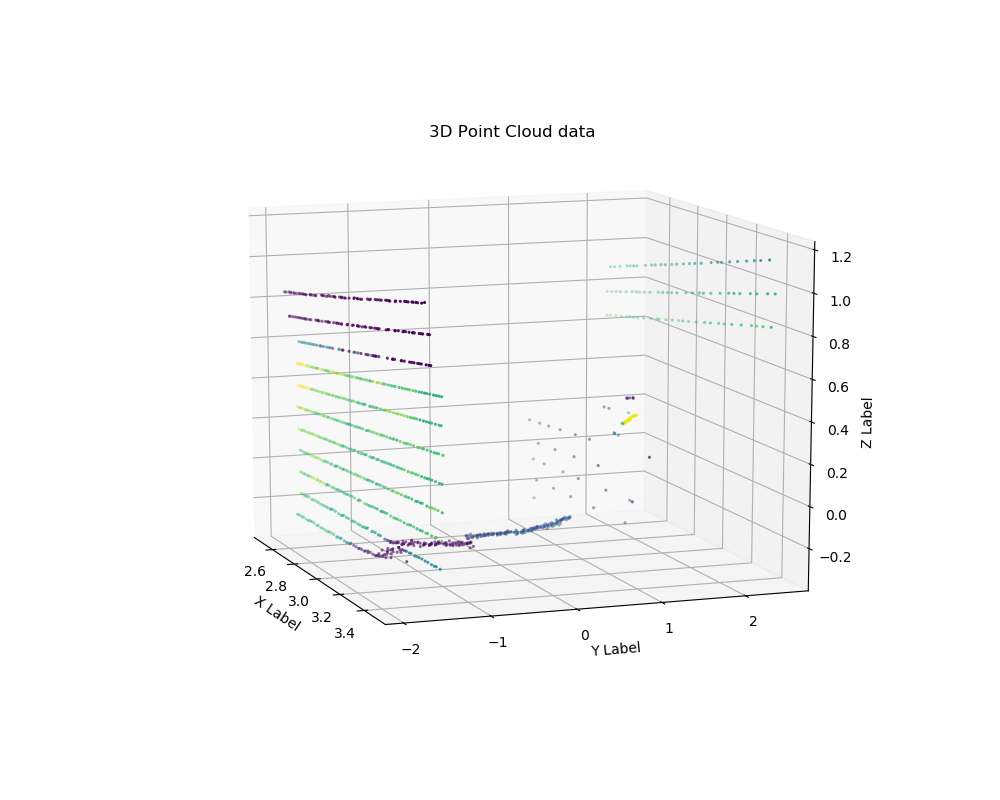

In [36]:
plot_pointcloud3d(start)

<IPython.core.display.Javascript object>


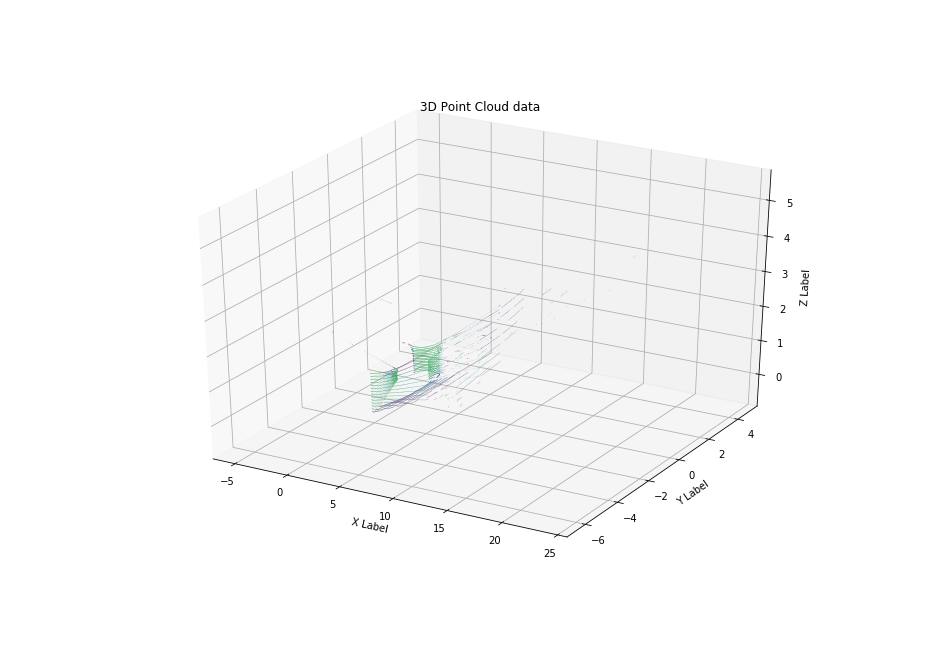

In [37]:
plot_pointcloud3d(end)

### 3D Plot using pptk
See documentation [here](https://heremaps.github.io/pptk/index.html). 
Example screenshot of interactive 3D visualzation:
<img src="files/pcl_1585676368204491882.png">

In [20]:
import pptk

In [14]:
v = pptk.viewer(start[['x', 'y', 'z']]) 
v.attributes(start['intensity'])
v.set(point_size=0.001)

In [46]:
v.capture('/home/brudermueller/Downloads/pcl_{}.png'.format(str(timesteps[0])))

In [22]:
len(timesteps)

282

In [23]:
# take only every 40th timestep
subsample = timesteps[::40]

In [24]:
len(subsample)

8

In [80]:
pcl = data[data.rosbagTimestamp == timesteps[150]].reset_index()
pcl = df_apply_rot(pcl)
pcl = remove_ground_points(pcl, -0.38)
pcl.head()
pcl = pcl[(pcl.x.between(2.9, 3.5)) & (pcl.y.between(-1, 2))]
v = pptk.viewer(pcl[['x', 'y', 'z']]) 
v.attributes(pcl['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=7)   

In [82]:
# save screenshot of lidar 3D plot for each timestep 
import time
for i,t in enumerate(timesteps[15:-1]): 
    pcl = data[data.rosbagTimestamp == t].reset_index()
    pcl = df_apply_rot(pcl)
    pcl = remove_ground_points(pcl, -0.38)
    pcl = pcl[(pcl.x.between(2.9, 3.5)) & (pcl.y.between(-1, 2))]
    v = pptk.viewer(pcl[['x', 'y', 'z']]) 
    v.attributes(pcl['intensity'])
    v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=8)    
    time.sleep(2)
    v.capture('/home/brudermueller/Downloads/{}m_pcl_groundtruth_{}.png'.format(str(walking_dist),i))
    time.sleep(2)
    v.close()

In [88]:
v = pptk.viewer(start_ground[['x', 'y', 'z']]) 
v.attributes(start_ground['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=10)

In [141]:
v = pptk.viewer(start[['x', 'y', 'z']]) 
v.attributes(start['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=10)